In [1]:
## Laden von der verschieden Bibliothek zur Daten Visualizierung und Vorhersagen
import os
import numpy as np
from matplotlib import pyplot
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression ,BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN
from keras.optimizers import rmsprop
from keras import backend as ker
from math import sqrt
import tensorflow as tf
from keras.layers import Convolution2D
os.chdir('/home/jupyter/jupyterNotebooks/m4competition18/data')
os.getcwd()



/home/jupyter/anaconda3/envs/jupyter/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'/home/jupyter/jupyterNotebooks/m4competition18/data'

In [2]:
df_hourly = pd.read_csv("Hourly-train.csv", skiprows=0, index_col =0)



Dataset_hourly = df_hourly.T.iloc[:,:]
print ("Dimension:  ",Dataset_hourly.shape,"\n")

Dimension:   (960, 414) 



In [3]:
## Laden von Dataset Weekly-train
df_weekly = pd.read_csv("Weekly-train.csv", skiprows=0, index_col =0)


Dataset_weekly = df_weekly.T
Weekly_train_Finance = df_weekly[59:223].T.iloc[:,:]
Weekly_train_Other = df_weekly[:12].T.iloc[:,:]
Weekly_train_Industry = df_weekly[53:59].T.iloc[:,:]
Weekly_train_Demographic = df_weekly[223:247].T.iloc[:,:]
Weekly_train_Micro = df_weekly[247:359].T.iloc[:,:]
Weekly_train_Macro = df_weekly[12:53].T.iloc[:,:]

print ("Dimension:  ",Dataset_weekly.shape,"\n")


Dimension:   (2597, 359) 



In [4]:
## Laden von  Dataset Yearly-train
df_yearly = pd.read_csv("Yearly-train.csv", skiprows=0, index_col =0)

yearly_train_Finance = df_yearly[15245:21764].T
yearly_train_Other = df_yearly[21764:23000].T
yearly_train_Industry = df_yearly[11529:15245].T
yearly_train_Demographic = df_yearly[10441:11529].T
yearly_train_Micro = df_yearly[3903:10441].T
yearly_train_Macro = df_yearly[:3903].T

Dataset_yearly = df_yearly.T.iloc[:,:]
print ("Dimension:  ",Dataset_yearly.shape,"\n")


Dimension:   (835, 23000) 



In [5]:
df_monthly = pd.read_csv("Monthly-train.csv", skiprows=0, index_col =0)
Dataset_monthly = df_monthly.T.iloc[:,:]
monthly_train_Finance = df_monthly[36736:47723].T
monthly_train_Other = df_monthly[47723:48000].T
monthly_train_Industry = df_monthly[26719:36736].T
monthly_train_Demographic = df_monthly[20991:26719].T
monthly_train_Micro = df_monthly[10016:20991].T
monthly_train_Macro = df_monthly[:10016].T
print ("Dimension:  ",Dataset_monthly.shape,"\n")


Dimension:   (2794, 48000) 



In [6]:
## Laden von Dataset Quarterly-train
df_quaterly = pd.read_csv("Quarterly-train.csv", skiprows=0, index_col =0)
Dataset_quaterly = df_quaterly.T.iloc[:,:]
quaterly_train_Finance = df_quaterly[17830:23135].T
quaterly_train_Other = df_quaterly[23135:24000].T
quaterly_train_Industry = df_quaterly[13193:17830].T
quaterly_train_Demographic = df_quaterly[11335:13193].T
quaterly_train_Micro = df_quaterly[5315:11335].T
quaterly_train_Macro = df_quaterly[:5315].T
print ("Dimension:  ",Dataset_quaterly.shape,"\n")


Dimension:   (866, 24000) 



In [7]:
df_daily = pd.read_csv("Daily-train.csv", skiprows=0, index_col =0)
Dataset_daily = df_daily.T
daily_train_Finance = df_daily[2035:3594].T
daily_train_Other = df_daily[3594:4227].T
daily_train_Industry = df_daily[1613:2035].T
daily_train_Demographic = df_daily[1603:1613].T
daily_train_Micro = df_daily[127:1603].T
daily_train_Macro = df_daily[:127].T
print ("Dimension:  ",Dataset_daily.shape,"\n")

Dimension:   (9919, 4227) 



In [8]:
def remov_nan (dataset):
    '''
    to remove all NaN Values in a 
    Time Serie Dataframe
    '''
    n = dataset.isnull().sum() 
    data = dataset[0:(len(dataset)-n)]
    return data

def copy_val(x):
    '''
    to copy a list or array in a new memory 
    without reference 
    x: list or array
    '''
    y =[]
    for i in x:
        y.append(i)
    return np.array(y)
## BENCHMARK ##
def smape(a, b):
    """
    Calculates sMAPE
    :param a: actual values
    :param b: predicted values
    :return: sMAPE
    """
    a = np.reshape(a, (-1,))
    b = np.reshape(b, (-1,))
    return np.mean(2.0 * np.abs(a - b) / (np.abs(a) + np.abs(b))).item() 

##===Mean Absolute Scaled Error ====##
def mase(insample, y_test, y_hat_test, freq):
    """
    Calculates MAsE
    :param insample: insample data
    :param y_test: out of sample target values
    :param y_hat_test: predicted values
    :param freq: data frequency
    :return:
    """
    y_hat_naive = []
    for i in range(freq, len(insample)):
        y_hat_naive.append(insample[(i - freq)])
    masep = np.mean(abs(insample[freq:] - y_hat_naive))
    return np.mean(abs(y_test - y_hat_test)) / masep
#Hier wird die "Time serie" als "spervised learning Problem" umgewandel.
#Die Datenmenge der Zeitreihen wird in Training und Testing Datamenge und jeweils in input & output Daten

# Hilfsfunktion , die eine Datenmenge in input und output Menge aufteile 
def split_input_output(dataset: np.ndarray, in_back: int=1) -> (np.ndarray, np.ndarray):
    """ 
    The function takes two arguments: the `dataset`, which is a NumPy array that we want to convert into a dataset,
    and the `in_back`, which is the number of previous time steps to use as input variables
    to predict the next time period — in this case defaulted to 1.
    :dataset: numpy dataset
    :in_variable: number of previous time steps as int
    :return: tuple of input and output dataset
    """
    Input, Output = [], []
    for i in range(len(dataset)-in_back):
        a = dataset[i:(i+in_back)]
        Input.append(a)
        Output.append(dataset[i + in_back])
    return np.array(Input), np.array(Output)

## Folgende Funktion split die Datenmende in Training and Testing Daten.

def split_into_train_test(dataset: np.ndarray,train_size, in_back) -> (np.ndarray, np.ndarray):
    """
    Splits dataset into training and test datasets. 
    : dataset: (np.ndarray) Time serie Dataset 
    : train_size: (int) Größe der Training Datamenge
    : look_back: (int) number of previous time steps 
    :return: tuple of training data and test dataset
    """
    if not train_size > in_back:
        raise ValueError('train_size muss größer als look_back',"train_size:",train_size,"in_back:",in_back)
    train= dataset[0:train_size]
    test = dataset[train_size - in_back:len(dataset)]
    #print('train_dataset: {}, test_dataset: {}'.format(len(train), len(test)))
    return train, test

## Es wird hier die Datenmenge in X_train,Y_train für das Training und X_test,Y_test für das Testing 

def all_split (dataset: np.ndarray,fh, in_back) -> (np.ndarray, np.ndarray, np.ndarray, np.ndarray):
    """
    Splits dataset into input-training (X_train), outout_training(Y_train) and input_test(X_test) , output_test(Y_test) datasets.
    : dataset:(np.ndarray) Time serie Dataset
    :df:(float64) Größe der Testing Datamenge 
    : in_back: (int) number of previous time steps 
    :return: x_train, y_train, x_test, y_test
    """
    #if not (size_prozent>0 and size_prozent<1):
        #raise ValueError('size_prozent of training must be in the interval 0 and 1')
    train_size = len(dataset)-fh
    training, testing = split_into_train_test(dataset,train_size,in_back)
    X_train, Y_train = split_input_output(training,in_back)
    X_test, Y_test = split_input_output(testing,in_back)
    return X_train,Y_train,X_test[0].reshape(1,-1),Y_test

def check_pred (dataset: pd.DataFrame,y_pred: np.ndarray):
    ''''
    this function check the negativity of the predicted values, set them to null 
    if they are negativ and to max value of the serie data if they are extrem high
    : dataset: Dataset of the serie
    : y_pred:  The list of predicted values
    : return:
    '''
    for i in range(len(y_pred)):
        if y_pred[i]<0:
            y_pred[i]=0
        if y_pred[i]> (9000*max(dataset)):
            y_pred[i]=max(dataset)

def Lin_Reg():
    model = LinearRegression(normalize=True)
    return model

def LinReg_mod(x_train, y_train, x_test,forcast_horizon):
    '''
    This function return the prediction of x_test with 
    the model 'linear Regression'. The parameter 'normalize' of the model will be set on True
    : x_train: Input Training Dataset
    : y_train: Outpout Training Dataset
    : x_test: Input Testing Dataset
    : forcast_horizon: the horizon of forcasting
    '''
    y_predict = []
    # load of the model and setting of parameters
    model = LinearRegression(normalize=True)   #ARDRegression(compute_score=True)
    # Training of the model with x_train and y_train
    model.fit(x_train,y_train)
    # prediction of the model
    prediction_current = model.predict(x_test)[0]
    # Techniques of Iteration for the horizon forcasting
    for i in range(0, forcast_horizon):
        # add the first prediction to y_predict
        y_predict.append(prediction_current)
        # move the first element in x_test to the last position, in order to remove 
        x_test[0] = np.roll(x_test[0], -1)
        # set now the current_prediction value at the last position of x_test
        x_test[0][(len(x_test[0]) - 1)] = prediction_current
        prediction_current = model.predict(x_test)[0]
    return  np.asarray(y_predict) 

def Dtree_Reg  (x_train, y_train, x_test, fh):
    '''
    This function return the prediction of x_test with 
    the model 'Decision Tree Regression'. 
    : x_train: Input Training Dataset
    : y_train: Outpout Training Dataset
    : x_test: Input Testing Dataset
    : fh: the horizon of forcasting
    '''
    y_predict = []
    # load of the model and setting of parameters
    model = DecisionTreeRegressor(criterion='mae',max_depth=28,min_samples_split=5,
                                 min_samples_leaf =5)
    # Training of the model with x_train and y_train
    model.fit(x_train,y_train)
    # prediction of the model
    prediction_current = model.predict(x_test)[0]
    # Techniques of Iteration for the horizon forcasting
    for i in range(0, fh):
        # add the first prediction to y_predict
        y_predict.append(prediction_current)
        # move the first element in x_test to the last position, in order to remove 
        x_test[0] = np.roll(x_test[0], -1)
        # set now the current_prediction value at the last position of x_test
        x_test[0][(len(x_test[0]) - 1)] = prediction_current
        prediction_current = model.predict(x_test)[0]
    return  np.asarray(y_predict) 

def K_neaReg (x_train, y_train, x_test, fh):
    
    '''
    This function return the prediction of x_test with 
    the model 'k-nearest neighbours'. 
    : x_train: Input Training Dataset
    : y_train: Outpout Training Dataset
    : x_test: Input Testing Dataset
    : forcast_horizon: the horizon of forcasting
    '''
    
    y_predict = []
    # load of the model and setting of parameters
    model = KNeighborsRegressor(n_neighbors=5)
    # Training of the model with x_train and y_train
    model.fit(x_train,y_train)
    # prediction of the model
    prediction_current = model.predict(x_test)[0]
    # Techniques of Iteration for the horizon forcasting
    for i in range(0, fh):
        # add the first prediction to y_predict
        y_predict.append(prediction_current)
        # move the first element in x_test to the last position, in order to remove 
        x_test[0] = np.roll(x_test[0], -1)
        # set now the current_prediction value at the last position of x_test
        x_test[0][(len(x_test[0]) - 1)] = prediction_current
        prediction_current = model.predict(x_test)[0]
    return  np.asarray(y_predict) 

def SVM_Reg (x_train, y_train, x_test, fh):
    
    '''
    This function return the prediction of x_test with 
    the model 'Support Vector Regression'. 
    : x_train: Input Training Dataset
    : y_train: Outpout Training Dataset
    : x_test: Input Testing Dataset
    : fh: the horizon of forcasting
    '''
    y_predict = []
    # load of the model and setting of parameters
    model =  SVR(kernel='rbf', C=1e3, gamma=0.1)
    # Training of the model with x_train and y_train
    model.fit(x_train,y_train)
    # prediction of the model
    prediction_current = model.predict(x_test)[0]
    # Techniques of Iteration for the horizon forcasting
    for i in range(0, fh):
        # add the first prediction to y_predict
        y_predict.append(prediction_current)
        # move the first element in x_test to the last position, in order to remove 
        x_test[0] = np.roll(x_test[0], -1)
        # set now the current_prediction value at the last position of x_test
        x_test[0][(len(x_test[0]) - 1)] = prediction_current
        prediction_current = model.predict(x_test)[0]
    return  np.asarray(y_predict)     



In [73]:
def main_prediction (Data: pd.DataFrame,model,fh,freq):
    
    
    n = Data.shape[1]   # number of Serie in the Dataset
    
    Lin_Reg_MASE =[]     # a list to save all mase_values of linear regression of each Serie forcasting 
    Lin_Reg_sMAPE =[]    # a list to save all smape_values of linear regression of each Serie forcasting
    
    c =0
    # Iteration through each serie in the dataset
    for i in range(n):
        zr = Data.iloc[:,i]
        
        # remove all NaN value from the serie
        new_Data = remov_nan (zr)
        
        in_back = int(0.3*len(new_Data))
        # load the value of new_Data
        Data_val = new_Data.values
        
        x_train,y_train,x_test,y_test = all_split(Data_val,fh, in_back)
        
        model.fit(x_train,y_train)
        
        predict =[]
        prediction_current = model.predict(x_test)[0]
        # Techniques of Iteration for the horizon forcasting
        for i in range(0, fh):
            # add the first prediction to y_predict
            predict.append(prediction_current)
            # move the first element in x_test to the last position, in order to remove 
            x_test[0] = np.roll(x_test[0], -1)
            # set now the current_prediction value at the last position of x_test
            x_test[0][(len(x_test[0]) - 1)] = prediction_current
            prediction_current = model.predict(x_test)[0]
        Y_pred_LinReg = np.asarray(predict) 

       
        # check the prediction on negativity and extremity
        check_pred(new_Data,Y_pred_LinReg)
        
        # calculation of Error
        Lin_Reg_sMAPE.append(smape(y_test, Y_pred_LinReg))

        Lin_Reg_MASE.append(mase(new_Data[:-fh], y_test, Y_pred_LinReg, freq))
        
    
        c+=1
    return  np.mean(Lin_Reg_sMAPE),  np.mean(Lin_Reg_MASE)
    # Printing
    #print("number of Time Series:",c)
    
    #print("\n---------FINAL RESULTS---------")
    
    #print("===========  sMAPE  =============\n")
    
    #print("#### Lin_Reg ####\n", np.mean(Lin_Reg_sMAPE), "\n")


    #print("============  MASE  =============")
    
    #print("#### Lin_Reg ####\n", np.mean(Lin_Reg_MASE), "\n\n")
    

In [97]:
main_prediction(Weekly_train_Industry,Lin_Reg(),13,1)

(0.3477356072314482, 6.6741452890844135)

In [113]:
def global_prediction(model):
    # Hourly Daten
    sMape_hourly_general,Mase_hourly_general = main_prediction(Weekly_train_Industry,model,48,24)
   
    # Daily daten
    
    sMape_daily_general, Mase_daily_general = main_prediction(Weekly_train_Industry,model,14,1)
    sMape_daily_Macro, Mase_daily_Macro = main_prediction(Weekly_train_Industry,model,14,1)
    sMape_daily_Micro, Mase_daily_Micro = main_prediction(Weekly_train_Industry,model,14,1)
    sMape_daily_Industry, Mase_daily_Industry = main_prediction(Weekly_train_Industry,model,14,1)
    sMape_daily_Demographic, Mase_daily_Demographic = main_prediction(Weekly_train_Industry,model,14,1)
    sMape_daily_Finance, Mase_daily_Finance = main_prediction(Weekly_train_Industry,model,14,1)
    sMape_daily_Other, Mase_daily_Other = main_prediction(Weekly_train_Industry,model,14,1)
    
    # Weekly daten
    sMape_weekly_general,Mase_weekly_general = main_prediction(Weekly_train_Industry,model,13,1)
    sMape_weekly_Macro,Mase_weekly_Macro = main_prediction(Weekly_train_Industry,model,13,1)
    sMape_weekly_Micro,Mase_weekly_Micro = main_prediction(Weekly_train_Industry,model,13,1)
    sMape_weekly_Industry,Mase_weekly_Industry = main_prediction(Weekly_train_Industry,model,13,1)
    sMape_weekly_Demographic,Mase_weekly_Demographic = main_prediction(Weekly_train_Industry,model,13,1)
    sMape_weekly_Finance,Mase_weekly_Finance = main_prediction(Weekly_train_Industry,model,13,1)
    sMape_weekly_Other,Mase_weekly_Other = main_prediction(Weekly_train_Industry,model,13,1)
    
    
    # Monthly Daten
    sMape_monthly_general,Mase_monthly_general= main_prediction(Weekly_train_Industry,model,18,12)
    sMape_monthly_Macro,Mase_monthly_Macro= main_prediction(Weekly_train_Industry,model,18,12)
    sMape_monthly_Micro,Mase_monthly_Micro= main_prediction(Weekly_train_Industry,model,18,12)
    sMape_monthly_Industry,Mase_monthly_Industry= main_prediction(Weekly_train_Industry,model,18,12)
    sMape_monthly_Demographic,Mase_monthly_Demographic= main_prediction(Weekly_train_Industry,model,18,12)
    sMape_monthly_Finance,Mase_monthly_Finance= main_prediction(Weekly_train_Industry,model,18,12)
    sMape_monthly_Other,Mase_monthly_Other= main_prediction(Weekly_train_Industry,model,18,12)
    
    
    # Quaterly Daten
    sMape_quaterly_general,Mase_quaterly_general= main_prediction(Weekly_train_Industry,model,8,4)
    sMape_quaterly_Macro,Mase_quaterly_Macro= main_prediction(Weekly_train_Industry,model,8,4)
    sMape_quaterly_Micro,Mase_quaterly_Micro= main_prediction(Weekly_train_Industry,model,8,4)
    sMape_quaterly_Industry,Mase_quaterly_Industry= main_prediction(Weekly_train_Industry,model,8,4)
    sMape_quaterly_Demographic,Mase_quaterly_Demographic= main_prediction(Weekly_train_Industry,model,8,4)
    sMape_quaterly_Finance,Mase_quaterly_Finance= main_prediction(Weekly_train_Industry,model,8,4)
    sMape_quaterly_Other,Mase_quaterly_Other= main_prediction(Weekly_train_Industry,model,8,4)
    
    # Yearly Daten
    sMape_yearly_general,Mase_yearly_general =main_prediction(Weekly_train_Industry,model,6,1)
    sMape_yearly_Macro,Mase_yearly_Macro =main_prediction(Weekly_train_Industry,model,6,1)
    sMape_yearly_Micro,Mase_yearly_Micro =main_prediction(Weekly_train_Industry,model,6,1)
    sMape_yearly_Industry,Mase_yearly_Industry =main_prediction(Weekly_train_Industry,model,6,1)
    sMape_yearly_Demographic,Mase_yearly_Demographic =main_prediction(Weekly_train_Industry,model,6,1)
    sMape_yearly_Finance,Mase_yearly_Finance =main_prediction(Weekly_train_Industry,model,6,1)
    sMape_yearly_Other,Mase_yearly_Other =main_prediction(Weekly_train_Industry,model,6,1)
    
    p = np.array([sMape_yearly_Macro,sMape_yearly_Macro,sMape_yearly_Macro])
    ds = pd.DataFrame({
        
    })
    print(ds)
    print(ds)
    

In [32]:
#===================PREDICTION FUNCTION =============================================##

In [9]:
### In Dieser Funktion werden  die Vorhersage mit Preprocessing und ohne preprocessing verglichen ,sowie our model with the Benchmark model

def one_ts_pred_compare(data: pd.DataFrame,fh,freq,in_back):
    '''
    this function split a dataset of one serie into training and testing Dataset, 
    train a mondel on the training dataset and make prediction on the test data. 
    it calculate the evaluation metric sMAPE and MASE of the prediction-it plots
    also the true values and the predicted values
    : data:     Dataset of the serie
    : in_back:  number of input point use to forcaste
    : return:  Y_test, Y_predict, sMAPE, MASE of each used model
    '''
    # ==== remove all Nan values from serie ====#
    new_Data = remov_nan (data)
    
    # ======= prediction without preprocessing
    x_train,y_train, x_test, y_test = all_split(new_Data, fh, in_back)
    
    
  #  YYY = rnn_bench(x_train, y_train, copy_val(x_test),fh, in_back)
    
    
    Y = K_neaReg(x_train, y_train, copy_val(x_test),fh)
    
    YY = mlp_bench(x_train, y_train, copy_val(x_test), fh)
  
    
    
    
    # ==== remove seasonality ====#
    seasonality_in = deseasonalize(new_Data, freq)
    for i in range(0, len(new_Data)):
        new_Data[i] = new_Data[i] * 100 / seasonality_in[i % freq]

    # ==== detrending ====#
    a, b = detrend(new_Data)
    for i in range(0, len(new_Data)):
        new_Data[i] = new_Data[i] - ((a * i) + b)
    
    
    # ==== Split the dataset into x_train,y_train, x_test and y_test ====#
    X_train,Y_train, X_test, Y_test = all_split(new_Data, fh, in_back)

    # ==== forcasting with the models ====#
    
    #print("second:  ",X_test)
    
    Y_pred = K_neaReg(X_train, Y_train, copy_val(X_test),fh) 
   # y_hat_test_RNN = rnn_bench(X_train, Y_train, copy_val(Y_test),fh, in_back)
    
    y_hat_test_MLP = mlp_bench(X_train, Y_train, copy_val(X_test), fh)
    
    
    
    # ==== add trend ====#
    for i in range(0, len(new_Data)):
        new_Data[i] = new_Data[i] + ((a * i) + b)
    
    for i in range(0, fh):
        Y_pred[i] = Y_pred[i] + ((a * (len(new_Data) + i + 1)) + b)
        y_hat_test_MLP[i] = y_hat_test_MLP[i] + ((a * (len(new_Data) + i + 1)) + b)
    #    y_hat_test_RNN[i] = y_hat_test_RNN[i] + ((a * (len(new_Data) + i + 1)) + b)

    # ==== add seasonality ====#
    for i in range(0, len(new_Data)):
        new_Data[i] = new_Data[i] * seasonality_in[i % freq] / 100
    
    for i in range(len(new_Data), len(new_Data) + fh):
        Y_pred[i - len(new_Data)] = Y_pred[i - len(new_Data)] * seasonality_in[i % freq] / 100
        y_hat_test_MLP[i - len(new_Data)] = y_hat_test_MLP[i - len(new_Data)] * seasonality_in[i % freq] / 100
   #     y_hat_test_RNN[i - len(new_Data)] = y_hat_test_RNN[i - len(new_Data)] * seasonality_in[i % freq] / 100
       
    
    # ==== check of the predicted values (Negativity and Extremity) ====#
    
    check_pred(new_Data,Y)
    check_pred(new_Data,YY)
  #  check_pred(new_Data,YYY)
    
    check_pred(new_Data,Y_pred)
    check_pred(new_Data,y_hat_test_MLP)
 #   check_pred(new_Data,y_hat_test_RNN)
   
    
    
    # ===== evaluation of the prediction for each model ====#
    
    
    Y_pred_mase = mase(new_Data[:-fh],y_test,Y_pred,freq)
    Y_pred_smape = smape(y_test,Y_pred)
    
    MLP_mase = mase(new_Data[:-fh],y_test,y_hat_test_MLP ,freq)
    MLP_smape = smape(y_test,y_hat_test_MLP )
    
  #  RNN_mase = mase(new_Data[:-fh],y_test,y_hat_test_RNN  ,freq)
 #   RNN_smape = smape(y_test,y_hat_test_RNN)
    
    Y_mase = mase(new_Data[:-fh],y_test,Y,freq)
    Y_smape = smape(y_test,Y)
    
    YY_mase = mase(new_Data[:-fh],y_test,YY,freq)
    YY_smape = smape(y_test,YY)
    
   # YYY_mase = mase(new_Data[:-fh],y_test,YYY,freq)
  #  YYY_smape = smape(y_test,YYY)
    
    
    # === print of Evaluation´s results and plotting ====#
    
    # Verglich between Preprocessing and no Preprocessing
    print("#===Comparison of our Model between 'with preprocessing' and 'no preprocessing'=====#","\n")
    print("** WITH PREPROCESSING (TREND AND SAISONNALITY) **","\n\n")
    print(" Y_pred_mase =  ",Y_pred_mase)
    print(" Y_pred_smape =  ",Y_pred_smape, "\n\n")
    
    print("** NO PREPROCESSING **","\n\n")
    print(" Y_pred_mase =  ",Y_mase)
    print(" Y_pred_smape =  ",Y_smape, "\n\n")
    
    Y_predd = pd.DataFrame({'Y_pred_with_preproc' : Y_pred,
                            'Y_pred_no_preproc' : Y,
                        'Y_test' : y_test})
    Y_predd.plot(figsize=(20, 8))
    pyplot.show()  
    
    # Vergleich of our model with the Benchmark
    print("##=====  Comparison between our model and the Benchmark model =====##")
    print("** WITH PREPROCESSING (TREND AND SAISONNALITY) **","\n\n")
    print("Our Model:    ","Y_pred_mase = ",Y_pred_mase,"      ","Y_pred_smape = ",Y_pred_smape,"\n" )
    print("MPL Benchmark:   ","MLP_mase = ",MLP_mase,"      ","MLP_smape = ",MLP_smape,"\n" )
 #   print("RNN Benchmark:   ","RNN_mase = ",RNN_mase,"      ","RNN_smape = ",RNN_smape,"\n" )
    
    Y_predd0 = pd.DataFrame({'Our Model' : Y_pred,
                            'MPL_BENCHMARK' : y_hat_test_MLP,
                         #   'RNN_BENCHMARK' : y_hat_test_RNN,
                        'Y_test' : y_test})
    Y_predd0.plot(figsize=(20, 8))
    pyplot.show()  
    
    print("** NO PREPROCESSING **","\n\n")
    print("Our Model:    ","Y_pred_mase = ",Y_mase,"      ","Y_pred_smape = ",Y_smape,"\n" )
    print("MPL Benchmark:   ","MLP_mase = ",YY_mase,"      ","MLP_smape = ",YY_smape,"\n" )
 #   print("RNN Benchmark:   ","RNN_mase = ",YYY_mase,"      ","RNN_smape = ",YYY_smape,"\n" )
    
    Y_predd1 = pd.DataFrame({'Our Model' : Y,
                            'MPL_BENCHMARK' : YY,
                           # 'RNN_BENCHMARK' : YYY,
                        'Y_test' : y_test})
    Y_predd1.plot(figsize=(20, 8))
    pyplot.show()  
    
   


/home/jupyter/anaconda3/envs/jupyter/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


#===Comparison of our Model between 'with preprocessing' and 'no preprocessing'=====# 

** WITH PREPROCESSING (TREND AND SAISONNALITY) ** 


 Y_pred_mase =   2.863511771308645
 Y_pred_smape =   0.011189073685686102 


** NO PREPROCESSING ** 


 Y_pred_mase =   5.4073547927883086
 Y_pred_smape =   0.021269548351943272 




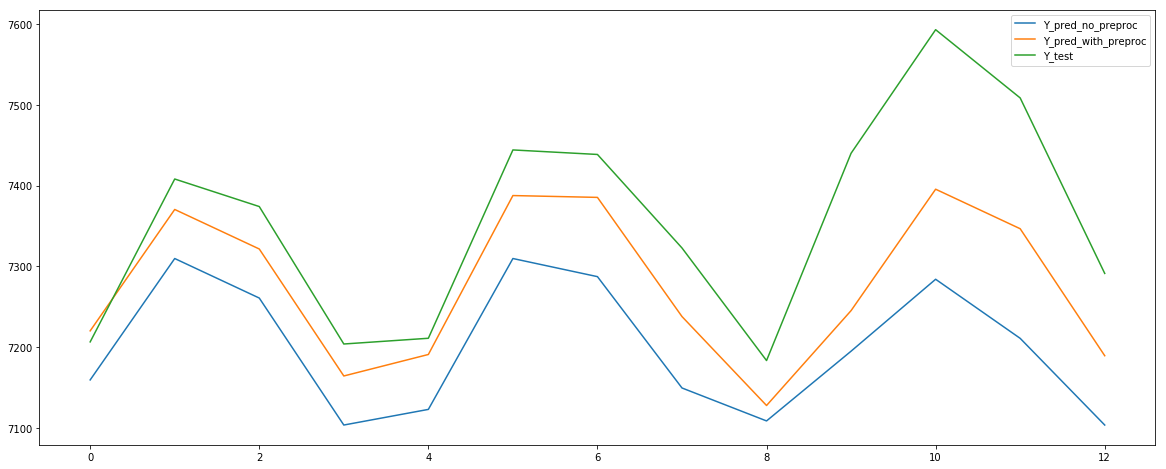

##=====  Comparison between our model and the Benchmark model =====##
** WITH PREPROCESSING (TREND AND SAISONNALITY) ** 


Our Model:     Y_pred_mase =  2.863511771308645        Y_pred_smape =  0.011189073685686102 

MPL Benchmark:    MLP_mase =  3.854234336724065        MLP_smape =  0.015037310163367316 



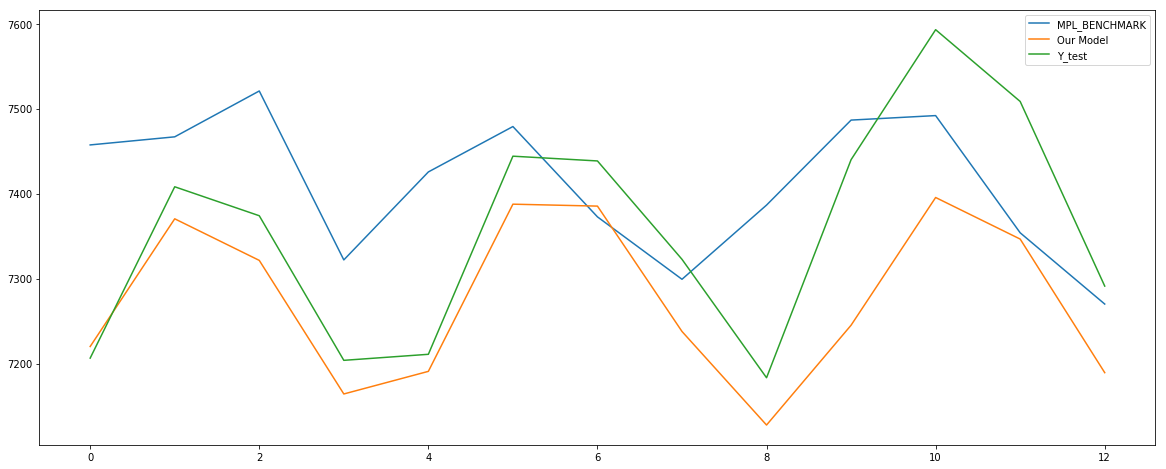

** NO PREPROCESSING ** 


Our Model:     Y_pred_mase =  5.4073547927883086        Y_pred_smape =  0.021269548351943272 

MPL Benchmark:    MLP_mase =  7.561352851015536        MLP_smape =  0.02915355163072225 



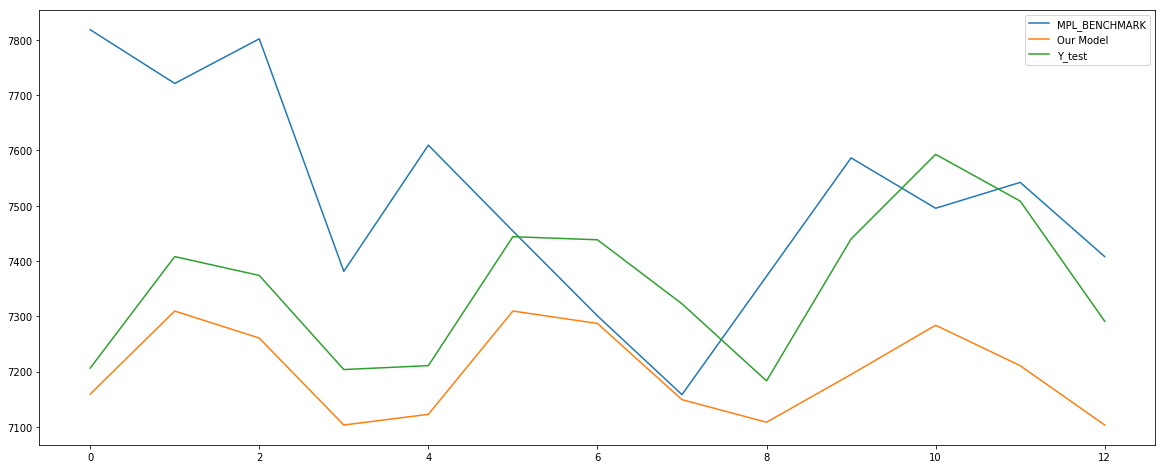

In [10]:
zt = Dataset_weekly.iloc[:,65]
one_ts_pred_compare(zt,13,1,65)

In [68]:
##============ Neuronal Netzwerk and Deep Learning =====================### 

In [25]:

def rnn_bench(x_train, y_train, x_test, fh, input_size):
    """
    Forecasts using 6 SimpleRNN nodes in the hidden layer and a Dense output layer
    :param x_train: train data
    :param y_train: target values for training
    :param x_test: test data
    :param fh: forecasting horizon
    :param input_size: number of points used as input
    :return:
    """
    # reshape to match expected input
    x_train = np.reshape(x_train, (-1, input_size, 1))
    x_test = np.reshape(x_test, (-1, input_size, 1))
    # create the model and parametrize it
    model = Sequential([
        SimpleRNN(13, input_shape=(input_size, 1), activation='linear',
                  use_bias=False, kernel_initializer='glorot_uniform',
                  recurrent_initializer='orthogonal', bias_initializer='zeros',
                  dropout=0.0, recurrent_dropout=0.0),
        Dense(1, use_bias=True, activation='linear')
    ])
    opt = rmsprop(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    # fit the model to the training data
    model.fit(x_train, y_train, epochs=100, batch_size=len(x_train), verbose=1)
    # make predictions
    y_hat_test = []
    last_prediction = model.predict(x_test)[0][0]
    for i in range(0, fh):
        y_hat_test.append(last_prediction)
        x_test[0] = np.roll(x_test[0], -1)
        x_test[0][(len(x_test[0]) - 1)] = last_prediction
        last_prediction = model.predict(x_test)[0][0]
        #print(last_prediction)
    return np.asarray(y_hat_test)


def LSTM_NN(x_train, y_train, x_test, fh, in_back):
    
    """
    Forecasts using 6 SimpleRNN nodes in the hidden layer and a Dense output layer
    :param x_train: train data
    :param y_train: target values for training
    :param x_test: test data
    :param fh: forecasting horizon
    :param input_size: number of points used as input
    :return:
    """    

    
    # reshape to match expected input
    x_train = np.reshape(x_train, (x_train.shape[0], in_back, 1))
    x_test = np.reshape(x_test, (x_test.shape[0], in_back, 1))
    
    # create the model and parametrize it
    model = Sequential()
    model.add(LSTM(10, input_shape=(in_back,1)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    
    # fit the model to the training dat
    model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=1)
    
    # make predictions
    y_hat_test = []
    last_prediction = model.predict(x_test)[0][0]
    for i in range(0, fh):
        y_hat_test.append(last_prediction)
        x_test[0] = np.roll(x_test[0], -1)
        x_test[0][(len(x_test[0]) - 1)] = last_prediction
        last_prediction = model.predict(x_test)[0][0]
        
    #print(last_prediction)
    return np.asarray(y_hat_test)

def Conv_NN(x_train, y_train, x_test, fh, in_back):
    
    """
    Forecasts using 2D convolutional in the hidden layer and a Dense output layer
    :param x_train: train data
    :param y_train: target values for training
    :param x_test: test data
    :param fh: forecasting horizon
    :param inback: number of points used as input
    :return:
    """
    
    # reshape to match expected input
    x_train = np.reshape(x_train, (-1, in_back, 1))
    x_test = np.reshape(x_test, (-1, in_back, 1))
    # create the model
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(5, 5), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    model.add(Conv2D(64, (5, 5), activation='relu'))
    model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01),
              metrics=['accuracy'])
    # fit the model to the training data
    model.fit(x_train, y_train, epochs=100, batch_size=1, verbose=1,
          callbacks=[history])
    # make predictions
    y_hat_test = []
    last_prediction = model.predict(x_test)[0]
    for i in range(0, fh):
        y_hat_test.append(last_prediction)
        x_test[0] = np.roll(x_test[0], -1)
        x_test[0, (len(x_test[0]) - 1)] = last_prediction
        last_prediction = model.predict(x_test)[0]
    return np.asarray(y_hat_test)



In [28]:
def one_ts_pred_neural_netzt(data: pd.DataFrame,fh,freq):
    '''
    this function split a dataset of one serie into training and testing Dataset, 
    train a mondel on the training dataset and make prediction on the test data. 
    it calculate the evaluation metric sMAPE and MASE of the prediction-it plots
    also the true values and the predicted values
    : data:     Dataset of the serie
    : in_back:  number of input point use to forcaste
    : return:  Y_test, Y_predict, sMAPE, MASE of each used model
    '''

    Data_val  = remov_nan (data)
       
    in_back = int(0.2*len(Data_val ))   
  
        # ==== remove seasonality ====#
    seasonality_in = deseasonalize(Data_val, freq)
    for i in range(0, len(Data_val)):
        Data_val[i] = Data_val[i] * 100 / seasonality_in[i % freq]

        # ==== detrending ====#
    a, b = detrend(Data_val)
    for i in range(0, len(Data_val)):
        Data_val[i] = Data_val[i] - ((a * i) + b)
        
        
        # Split the data into x_train, y_train, x_test, y_test
    x_train,y_train,x_test,y_test = all_split(Data_val,fh, in_back)
        
        # Prediction with a deep learning model
        
    Y_pred = Conv_NN(x_train, y_train, copy_val(x_test),fh, in_back)
        
     # ==== add trend ====#
    for i in range(0, len(Data_val)):
        Data_val[i] = Data_val[i] + ((a * i) + b)
    
    for i in range(0, fh):
        Y_pred[i] = Y_pred[i] + ((a * (len(Data_val) + i + 1)) + b)
           
    # ==== add seasonality ====#
    for i in range(0, len(Data_val)):
        Data_val[i] = Data_val[i] * seasonality_in[i % freq] / 100
    
    for i in range(len(Data_val), len(Data_val) + fh):
        Y_pred[i - len(Data_val)] = Y_pred[i - len(Data_val)] * seasonality_in[i % freq] / 100
        
        
    X_train,Y_train, X_test, Y_test = all_split(Data_val, fh, in_back)
    
    
    # check of the predicted values
    check_pred(Data_val,Y_pred)
      
    # evaluation of the prediction for each model
    
    model_mase = mase(Data_val[:-fh],Y_test,Y_pred,freq)
    model_smape = smape(Y_test,Y_pred)
    

    #print of the evaluation metrics for each model and plotting of the prediction to compare with the real values
   
    print("Simple Recurrent Neuronal Netzwerk","\n")
    print(" model_mase =  ",model_mase)
    print(" model_smape =  ",model_smape, "\n\n")
    
    print(Y_test)
    print(Y_pred)
    plot_prediction(Y_test,Y_pred)

In [31]:
one_ts_pred_neural_netzt(Dataset_yearly.iloc[:,30],6,1)

NameError: name 'Conv2D' is not defined

In [48]:
def set_ts_pred_neural_netzt(data: pd.DataFrame,fh,freq):
    '''
    this function make the prediction of each time serie of a set of time serie,
    calculates the evaluation metric sMAPE and MASE of all the predictions and return 
    the mean of the all sMape values and also of all Mase values.
    : data:     Dataset of the serie
    : in_back:  number of input point use to forcaste
    : return:  Y_test, Y_predict, sMAPE, MASE of each used model
    '''
   

    n = Data.shape[1]   # number of Serie in the Dataset
    
    model_MASE =[]     # a list to save all mase_values of linear regression of each Serie forcasting 
    model_sMAPE =[]    # a list to save all smape_values of linear regression of each Serie forcasting
    
    c =0
    # Iteration through each serie in the dataset
    for i in range(n):
        Data = Data.iloc[:,i]
        



        Data_val  = remov_nan (data)
        #print(Data_val.head)
        in_back = int(0.2*len(Data_val ))
        # load the value of new_Data
        # = new_Data.values
        
        
        
        # ==== remove seasonality ====#
        seasonality_in = deseasonalize(Data_val, freq)
        for i in range(0, len(Data_val)):
        Data_val[i] = Data_val[i] * 100 / seasonality_in[i % freq]

        # ==== detrending ====#
    a, b = detrend(Data_val)
    for i in range(0, len(Data_val)):
        Data_val[i] = Data_val[i] - ((a * i) + b)
        
        
        # Split the data into x_train, y_train, x_test, y_test
    x_train,y_train,x_test,y_test = all_split(Data_val,fh, in_back)
        
        # Prediction with a deep learning model
        
    Y_pred = rnn_bench(x_train, y_train, copy_val(x_test),fh, in_back)
        
     # ==== add trend ====#
    for i in range(0, len(Data_val)):
        Data_val[i] = Data_val[i] + ((a * i) + b)
    
    for i in range(0, fh):
        Y_pred[i] = Y_pred[i] + ((a * (len(Data_val) + i + 1)) + b)
           
    # ==== add seasonality ====#
    for i in range(0, len(Data_val)):
        Data_val[i] = Data_val[i] * seasonality_in[i % freq] / 100
    
    for i in range(len(Data_val), len(Data_val) + fh):
        Y_pred[i - len(Data_val)] = Y_pred[i - len(Data_val)] * seasonality_in[i % freq] / 100
        
        
    X_train,Y_train, X_test, Y_test = all_split(Data_val, fh, in_back)
    
    
    # check of the predicted values
    check_pred(Data_val,Y_pred)
      
    # evaluation of the prediction for each model
    
    model_mase = mase(Data_val[:-fh],Y_test,Y_pred,freq)
    model_smape = smape(Y_test,Y_pred)
    

    #print of the evaluation metrics for each model and plotting of the prediction to compare with the real values
   
    print("Simple Recurrent Neuronal Netzwerk","\n")
    print(" model_mase =  ",model_mase)
    print(" model_smape =  ",model_smape, "\n\n")
    
    print(Y_test)
    print(Y_pred)
    plot_prediction(Y_test,Y_pred)
    

In [23]:
zt = Dataset_monthly.iloc[:,10]
print(remov_nan(zt).shape)
one_ts_pred_neural_netzt(zt,6,1)

(618,)
Epoch 1/50
105/489 [=====>........................] - ETA: 36s - loss: 465347.8423

KeyboardInterrupt: 

In [90]:
d = {'col1': [1, 2], 'col2': [3, 4]}
dfdd = pd.DataFrame(data=d)
dfdd.head()

,col1,col2
0,1,3
1,2,4


In [ ]:
df.to_csv('out.csv',header=true)
